In [1]:
# import matplotlib 
# matplotlib.use("QtAgg")
import numpy as np
import matplotlib.pyplot as plt

from silx.image.projection import Projection
from ppfft.tools.pad import pad

# Radon transform

Theoretically, the projection slice theorem states that the 1D Fourier transform of the Radon transform gives samples of the DFT on a polar grid, which is what we need. However, our way of computing the polar DFT does not give the same results as this theorem.

We first implement the analytical Radon transform of the Shepp Logan phantom.

In [2]:
def radon_ellipse(A, a, b, phi, x0, y0, r, theta):

    r0_squared = a**2 * np.cos(theta - phi)**2 + b**2 * np.sin(theta - phi)**2

    dist_squared = (r - x0 * np.cos(theta) - y0 * np.sin(theta))**2

    res = np.zeros_like(r)

    mask = dist_squared < r0_squared

    res[mask] = 2 * A * a * b * np.sqrt(r0_squared[mask] - dist_squared[mask]) / r0_squared[mask]

    return res


def create_shepp_logan(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [2, -0.98, -0.02, -0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[:, ::-1]


def radon_shepp_logan(r, theta):

    A_list = [2, -0.98, -0.02, -0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    res = np.zeros(shape=(len(theta), len(r)))

    r_mesh, theta_mesh = np.meshgrid(r, theta)

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        res += radon_ellipse(A, a, b, phi, x0, y0, r_mesh, theta_mesh)

    return res


def create_shepp_logan_2(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[::-1]


def radon_shepp_logan_2(r, theta):

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    res = np.zeros(shape=(len(theta), len(r)))

    r_mesh, theta_mesh = np.meshgrid(r, theta)

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        res += radon_ellipse(A, a, b, phi, x0, y0, r_mesh, theta_mesh)

    return res


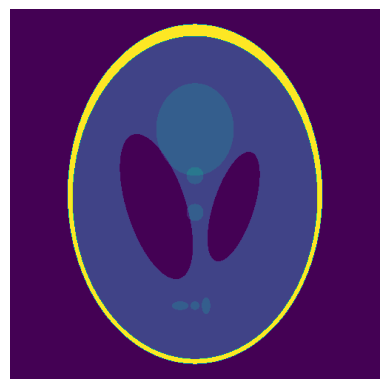

In [3]:
n = 500
phantom = create_shepp_logan_2(n)
plt.imshow(phantom)
plt.axis("off")
plt.show()

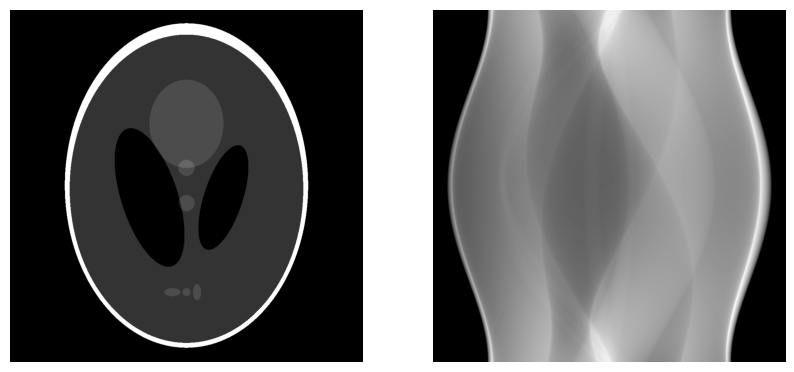

In [4]:
im = create_shepp_logan_2(1000)
proj = Projection(im.shape, angles=im.shape[0])
sinogram = proj.projection(im)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(im, cmap='gray')
axes[0].set_axis_off()

axes[1].imshow(sinogram, cmap='gray')
axes[1].set_axis_off()

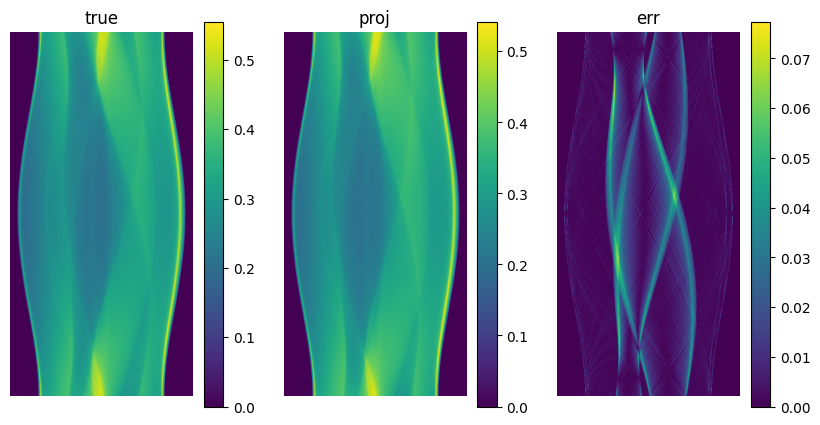

In [5]:
r = np.linspace(-1, 1, n)
theta = np.pi * np.arange(0, 2 * n) / (2 * n) # 2n angles from 0 to pi (pi excluded)
true_sinogram = radon_shepp_logan_2(r, theta)

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)
n_sinogram = 2/(n-1) * sinogram # normalization? multiply by step size in r direction

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for arr, ax, title in zip([true_sinogram,  n_sinogram, np.abs(true_sinogram - n_sinogram)], axes, ["true", "proj", 'err']):
    plt.colorbar(ax.imshow(arr), ax=ax)
    ax.set_title(title)
    ax.set_axis_off()


In [6]:
n = 1000
phantom = create_shepp_logan_2(n)

r = np.linspace(-1, 1, n)
theta = np.pi * np.arange(0, 2 * n) / (2 * n) # 2n angles from 0 to pi (pi excluded)
true_sinogram = radon_shepp_logan_2(r, theta)

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)
n_sinogram = 2/(n-1) * sinogram # normalization? multiply by step size in r direction

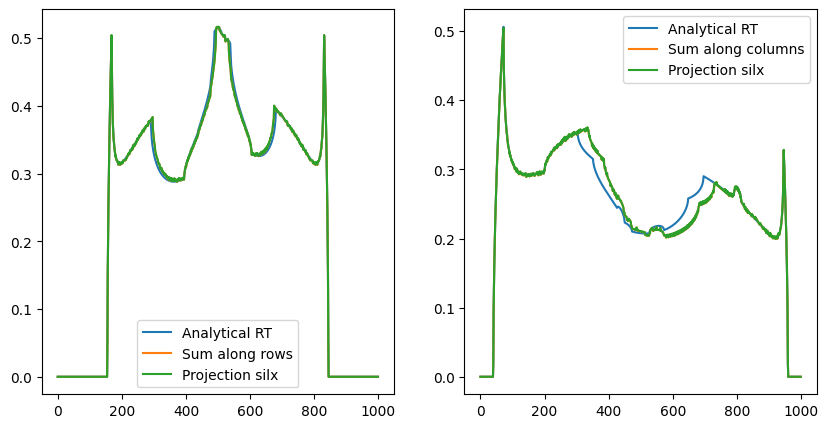

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(true_sinogram[0], label='Analytical RT')
axes[0].plot(np.sum(phantom, axis=0) / (n//2), label='Sum along rows')
axes[0].plot(n_sinogram[0], label='Projection silx')
axes[0].legend()

axes[1].plot(true_sinogram[n, ::-1], label='Analytical RT')
axes[1].plot(np.sum(phantom, axis=1) / (n//2), label='Sum along columns')
axes[1].plot(n_sinogram[n, ::-1], label='Projection silx')
axes[1].legend()

In [8]:
r = np.linspace(-1, 1, n)
theta = - np.pi / 2 + np.pi * np.arange(0, 2 * n) / (2 * n) # 2n angles from 0 to pi (pi excluded)
true_sinogram_new = radon_shepp_logan_2(r, theta)

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)
n_sinogram = 2/(n-1) * sinogram # normalization? multiply by step size in r direction

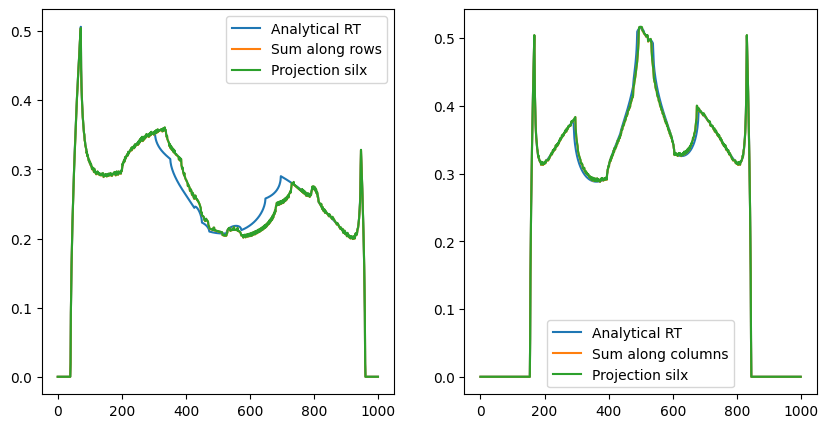

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(true_sinogram_new[0], label='Analytical RT')
axes[0].plot(np.sum(phantom, axis=1) / (n//2), label='Sum along rows')
axes[0].plot(n_sinogram[0], label='Projection silx')
axes[0].legend()

axes[1].plot(true_sinogram_new[n], label='Analytical RT')
axes[1].plot(np.sum(phantom, axis=0) / (n//2), label='Sum along columns')
axes[1].plot(n_sinogram[n], label='Projection silx')
axes[1].legend()

# Polar from Radon

All our transforms were samples of the following trigonometric polynomial:
$$
P(x, y) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ux + vy}{m} \right)
$$

where $m = 2n +1 $ and $\mathcal{D}(n) = \llbracket -n/2, n/2-1 \rrbracket$. The polar grid was:
$$
\left\{ \left( p \cos\left( \frac{\pi q}{2n} \right), p \sin\left( \frac{\pi q}{2n} \right) \right) \mid p \in \llbracket -n, n \rrbracket, q \in \llbracket 0, 2n-1 \rrbracket \right\}
$$

This is computed by the following function:

In [10]:
def polar_fourier_transform(im):
    n = len(im)
    m = 2 * n + 1
    half_n = n // 2
    p = np.arange(-n, n + 1) / m
    q = np.arange(2 * n)
    u, v = np.arange(-half_n, half_n), np.arange(-half_n, half_n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", p, u, np.cos(np.pi * q / (2 * n)))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", p, v, np.sin(np.pi * q / (2 * n)))

    res = np.einsum("uv,kul,kvl->lk", im, np.exp(cos), np.exp(sin))

    return res
   

In [11]:
n = 200
m = 2 * n + 1
phantom = create_shepp_logan_2(n)

theta = - np.pi / 2 +  np.pi * np.arange(2 * n) / (2 * n)

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)
pad_sino = pad(sinogram, (2 * n, m))
fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

In [12]:
polar_true = polar_fourier_transform(phantom)

We now need to make sure this can be computed by using the 1D Fourier transform of the Radon transform.

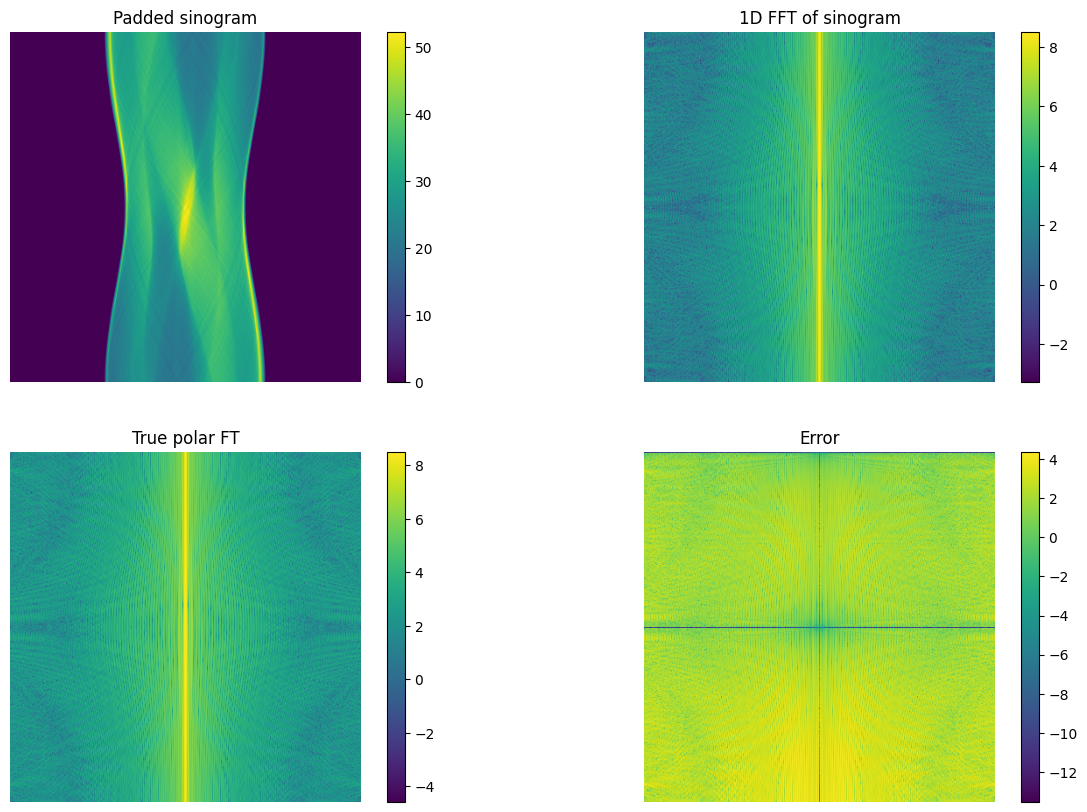

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

ims = [pad_sino, np.log(np.abs(fft_sinogram)), np.log(np.abs(polar_true)), np.log(np.abs(polar_true - fft_sinogram))]
titles = ["Padded sinogram", "1D FFT of sinogram", "True polar FT", "Error"]


for ax, arr, title in zip(axes.ravel(), ims, titles):
    plt.colorbar(ax.imshow(arr), ax=ax)
    ax.set_title(title)
    ax.set_axis_off()

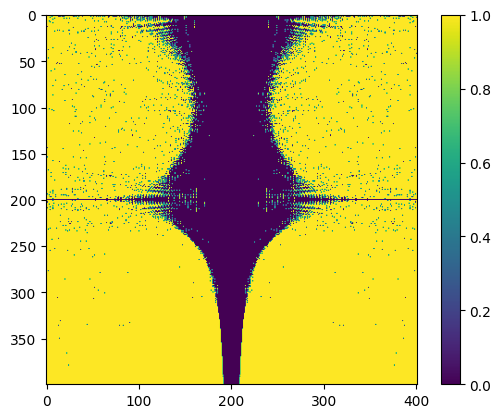

In [14]:
plt.imshow(np.log(np.abs(polar_true - fft_sinogram) / np.abs(polar_true)) >= -2)
plt.colorbar()

# Inversion from Radon

In [15]:
from ppfft.inverse.direct_inverse import direct_inversion
from ppfft.inverse.iterative_inverse import iterative_inverse
from ppfft.reconstruction.polar_to_pp import direct_2d_interp, polar_coordinates

In [16]:
n = 256
m = 2 * n + 1
phantom = create_shepp_logan_2(n)

phantom = plt.imread("Shepp_logan_240.png")
n = phantom.shape[0]
m = 2 * n + 1


theta = - np.pi / 2 +  np.pi * np.arange(2 * n) / (2 * n)

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)
pad_sino = pad(sinogram, (2 * n, m))
fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

In [17]:
polar_coords = polar_coordinates(n)

In [18]:
hori_ppfft, vert_ppfft = direct_2d_interp(fft_sinogram.flatten(), polar_coords[..., 0].T, polar_coords[..., 1].T, n)

In [19]:
sol_it = iterative_inverse(hori_ppfft, vert_ppfft, tol=1e-4)

[None, None, None, None]

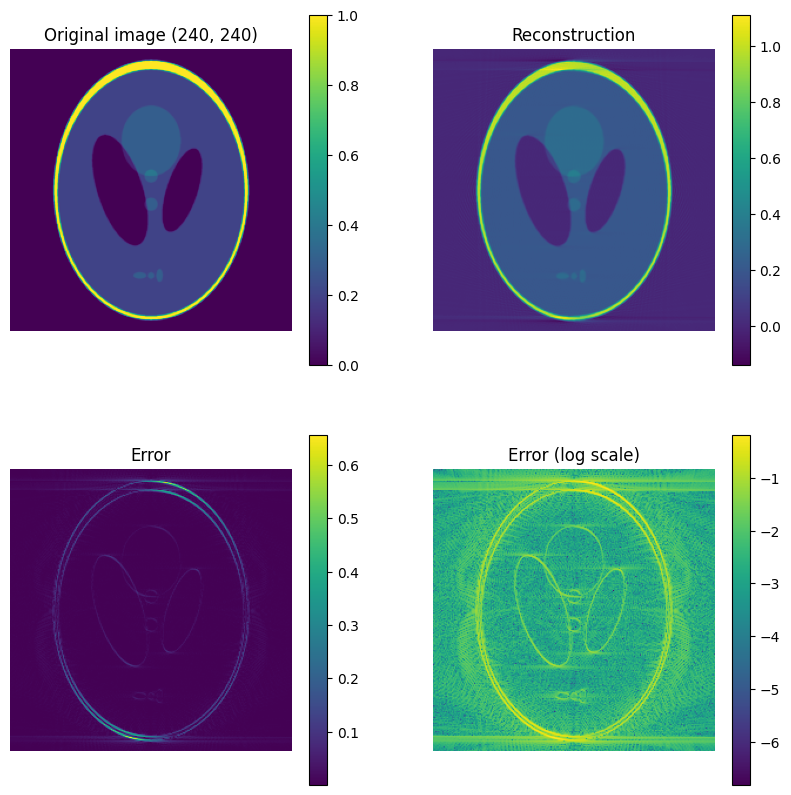

In [20]:
sol = sol_it[0].real

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

a = axes[0, 0].imshow(phantom)
plt.colorbar(a, ax=axes[0, 0])
axes[0, 0].set_title(f"Original image {phantom.shape}")

a = axes[0, 1].imshow(sol)
plt.colorbar(a, ax=axes[0, 1])
axes[0, 1].set_title(f"Reconstruction")

a = axes[1, 0].imshow(np.abs(sol - phantom))
plt.colorbar(a, ax=axes[1, 0])
axes[1, 0].set_title("Error")

a = axes[1, 1].imshow(np.log10(np.abs(sol - phantom)))
plt.colorbar(a, ax=axes[1, 1])
axes[1, 1].set_title("Error (log scale)")

[ax.set_axis_off() for ax in axes.ravel()]

In [21]:
def inversion_from_radon(sino, angles=None, tol=1e-3):
    """
    The angles of the projections are supposed to be:
    """

    n_theta, n = sino.shape

    pad_sino = pad(sinogram, (n_theta, 2 * n + 1))
    fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

    if angles is None:
        angles = np.linspace(- np.pi/2, np.pi/2, num=n_theta, endpoint=False)

    p = np.arange(-n, n + 1)

    x_polar = p[None, :] * np.cos(np.pi / 2 + angles)[:, None]
    y_polar = p[None, :] * np.sin(np.pi / 2 + angles)[:, None]

    hori_ppfft, vert_ppfft = direct_2d_interp(fft_sinogram, x_polar, y_polar, n)

    if tol is None:
        return direct_inversion(hori_ppfft, vert_ppfft)
    
    else:
        return iterative_inverse(hori_ppfft, vert_ppfft, tol)[0]


In [22]:
n = 256
m = 2 * n + 1
phantom = create_shepp_logan_2(n)

theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)

In [23]:
sol_it_2 = inversion_from_radon(sinogram, angles=theta)

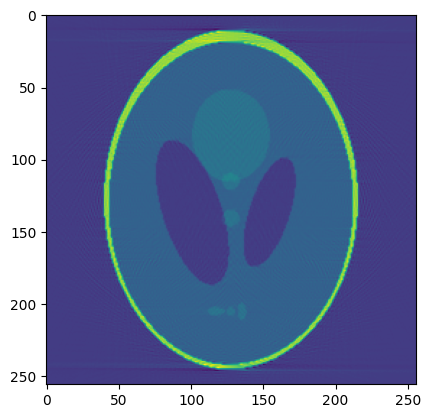

In [24]:
plt.imshow(sol_it_2.real)

In [25]:
sol = direct_inversion(hori_ppfft, vert_ppfft)

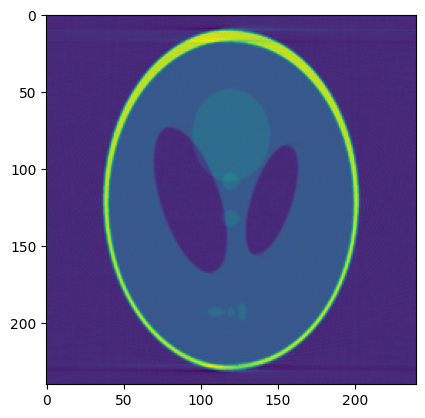

In [26]:
plt.imshow(sol.real)

# Radon transform

In [27]:
from ppfft.ppfft.ppfft import ppfft
from ppfft.tools.new_fft import new_ifft

In [28]:
def radon_transform(im):
    n = len(im)

    l = np.arange(-(n//2), n//2 + 1)
    Theta2 = np.arctan(2 * l / n) # from 3pi/4 to pi/4 (decreasing)
    Theta1 = np.pi / 2 - Theta2 # from -pi/4 to pi/4 (increasing)

    res = np.zeros(shape=(2 * n + 2, 2 * n + 1))

    hori, vert = ppfft(im)
    fft_hori = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(hori, axes=-1)), axes=-1)
    fft_vert = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(vert, axes=-1)), axes=-1)

    return np.concatenate((fft_hori, fft_vert[::-1, ::-1]), axis=0)


In [29]:
n = 300
im = create_shepp_logan_2(n)
my_radon = radon_transform(im)

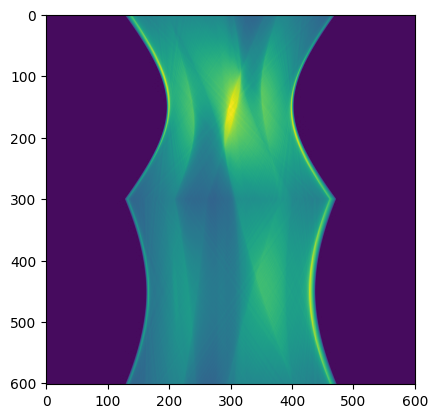

In [30]:
plt.imshow(my_radon.real)